# TensorFlow

Case study: Houses for sale

## Setup

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

print(tf.__version__)
sns.set_theme(style="ticks", color_codes=True)

## Data preparation

- See notebook ["Data"](https://kirenz.github.io/regression/docs/case-duke-exploration.html) for details about data preprocessing

In [ ]:
from case_duke_data_prep import *

In [ ]:
df.info()

In [ ]:
df

# Simple regression

- We start with a single-variable linear regression, to predict price from area.

In [ ]:
# Select features for simple regression
features = ['area']
X = df[features]

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

## Data splitting

In [ ]:
# Train Test Split
# Use random_state to make this notebook's output identical at every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear regression


- Training a model with tf.keras typically starts by defining the model architecture.

- In this case use a keras.Sequential model. This model represents a sequence of steps. In this case there is only one step:

  - Apply a linear transformation to produce 1 output using layers.Dense.


  
- The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

Build the sequential model:

In [ ]:
lm = tf.keras.Sequential([
    layers.Dense(units=1, input_shape=(1,))
])

lm.summary()

- Once the model is built, configure the training procedure using the Model.compile() method.

- The most important arguments to compile are the loss and the optimizer since these define what will be optimized (mean_absolute_error) and how (using the optimizers.Adam).

In [ ]:
lm.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error'
)

- Once the training is configured, use Model.fit() to execute the training:

In [ ]:
%%time

history = lm.fit(
    X_train, y_train,
    epochs=500,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

In [ ]:
y_train

In [ ]:
# Calculate R squared
y_pred = lm.predict(X_train).astype(np.int64)

r2_score(y_train, y_pred)  

In [ ]:
# slope coefficient
lm.layers[0].kernel

Visualize the model's training progress using the stats stored in the history object.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [price]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

Collect the results (mean squared error) on the test set, for later:

In [ ]:
test_results = {}

test_results['lm'] = lm.evaluate(
    X_test,
    y_test, verbose=0)

test_results

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [ ]:
x = tf.linspace(0.0, 6200, 6201)
y = lm.predict(x)

y

In [ ]:
def plot_area(x, y):
  plt.scatter(X_train['area'], y_train, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('area')
  plt.ylabel('price')
  plt.legend()

In [ ]:
plot_area(x,y)

# Multiple Regression

In [ ]:
# Select all relevant features
features= [
 'bed',
 'bath',
 'area',
 'year_built',
 'cooling',
 'lot'
  ]
X = df[features]

# Convert categorical to numeric
X = pd.get_dummies(X, columns=['cooling'], prefix='cooling', prefix_sep='_')

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

In [ ]:
from sklearn.model_selection import train_test_split

# Train Test Split
# Use random_state to make this notebook's output identical at every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lm_2 = tf.keras.Sequential([
    layers.Dense(units=1, input_shape=(7,))
])

lm_2.summary()

In [ ]:
lm_2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [111]:
%%time

history = lm_2.fit(
    X_train, y_train,
    epochs=500,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2
)

CPU times: user 6.7 s, sys: 430 ms, total: 7.13 s
Wall time: 6.52 s


In [112]:
# Calculate R squared
y_pred = lm_2.predict(X_train).astype(np.int64)
y_true = y_train.astype(np.int64)

r2_score(y_train, y_pred)  

0.008066631014296388

In [113]:
# slope coefficients
lm_2.layers[0].kernel

<tf.Variable 'dense_14/kernel:0' shape=(7, 1) dtype=float32, numpy=
array([[93.865845],
       [95.36067 ],
       [93.04233 ],
       [92.90618 ],
       [95.016266],
       [96.31462 ],
       [87.34802 ]], dtype=float32)>

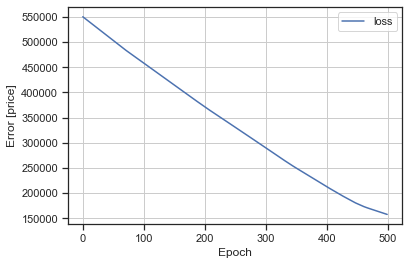

In [114]:
plot_loss(history)

In [115]:
test_results['lm_2'] = lm_2.evaluate(
    X_test, y_test, verbose=0)

# DNN regression

This model will contain a few more layers than the previous model:

- Two hidden, nonlinear, Dense layers using the relu nonlinearity.
- A linear single-output layer.

In [116]:
dnn_model = keras.Sequential([
      layers.Dense(units=1, input_shape=(7,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [117]:
%%time

history = dnn_model.fit(
    X_train, y_train,
    epochs=500,
    verbose=0,
    validation_split = 0.2)

CPU times: user 7.19 s, sys: 494 ms, total: 7.69 s
Wall time: 6.91 s


In [118]:
# Calculate R squared
y_pred = dnn_model.predict(X_train).astype(np.int64)
y_true = y_train.astype(np.int64)

r2_score(y_train, y_pred)  

0.3319246298888

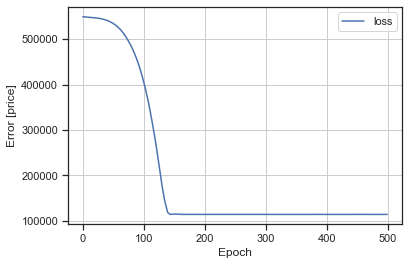

In [119]:
plot_loss(history)

In [120]:
test_results['dnn_model'] = dnn_model.evaluate(
    X_test, y_test, verbose=0)

# Performance comparison

In [121]:
pd.DataFrame(test_results, index=['Mean absolute error [price]']).T

,Mean absolute error [price]
lm,537925.625000
lm_2,145734.390625
dnn_model,103795.859375
